## 0. Loading the data and importing dependencies

In [ ]:
# import necessary dependencies
import matplotlib.pyplot as plt
%matplotlib inline

# import libraries
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

# load MNIST dataset
X_data, y_data = fetch_openml(name="mnist_784", return_X_y=True) # newest version is implicit. return_X_y parameter specifies returning labels as a separate vector.

In [ ]:
testSize = 1/7 # the percent of data which is partitioned off into the test set
randomState = 0  # ensure reproducibility of randomness

# Here we split the data into 60k training, 10k testing (same split as Yann LeCun), using our random state "randomState" to ensure consistency of results
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=testSize, random_state=randomState)

# X_train is a dataframe, so convert to numpy matrix. convert that into (N x 784) shape where N = number of samples
X_train = X_train.to_numpy().reshape((60000, 784))
y_train = y_train.to_numpy().reshape((60000, 1)).ravel()
X_test = X_test.to_numpy().reshape((10000, 784))
y_test = y_test.to_numpy().reshape((10000, 1)).ravel()

print(X_train.shape)
print(y_test.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(10000,)
(10000, 784)
(10000,)


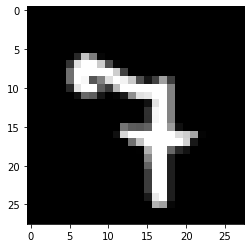

In [ ]:
# plot an image
plt.imshow(X_train[0].reshape((28,28)), cmap=plt.get_cmap('gray'))
plt.show()

## 1. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as knn

knn_train_accs = []
knn_test_accs = []

# p=1 Minkowski is same as SAD for k in range(1,11):
for k in range(1,11):
    knn_model = knn(n_neighbors=k, p=1, n_jobs=-1)
    knn_model.fit(X_train, y_train)

    #train_acc = knn_model.score(X_train, y_train) 
    test_acc = knn_model.score(X_test, y_test)
    #knn_train_accs.append(train_acc)
    knn_test_accs.append(test_acc)
    #print("Training accuracy: {}" .format(train_acc))
    print("Testing accuracy for K = {}: {}" .format(k, test_acc))

Testing accuracy for K = 1: 0.9659
Testing accuracy for K = 2: 0.9592
Testing accuracy for K = 3: 0.9675
Testing accuracy for K = 4: 0.9658
Testing accuracy for K = 5: 0.9659
Testing accuracy for K = 6: 0.9643
Testing accuracy for K = 7: 0.9641
Testing accuracy for K = 8: 0.9632
Testing accuracy for K = 9: 0.9623
Testing accuracy for K = 10: 0.9623


The accuracy of the test set on each value of $K$ is described in the plot below (or the outputs above). For $K=1$, the accuracy is 96.59%.

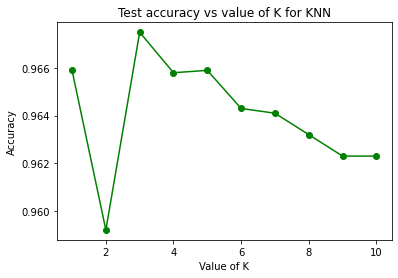

In [ ]:
plt.plot(range(1,11), knn_test_accs, 'o-g')
plt.ylabel('Accuracy')
plt.xlabel('Value of K')
plt.title('Test accuracy vs value of K for KNN')
plt.show()

## 2. MLP
Includes loading the dataset into tensor format and defining the 'train' procedure which updates the model parameters.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import transforms
import numpy as np
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# download train and test dataset, save them to "./content" as tensors
train_dataset = torchvision.datasets.MNIST('./content', train=True,
                                         transform=transforms.ToTensor(),
                                         download=True)
test_dataset = torchvision.datasets.MNIST('./content', train=False,
                                         transform=transforms.ToTensor(),
                                         download=True)
set1 = {'train':train_dataset, 'test':test_dataset}

# define dataloaders for train, test sets
dataloaders = {k: torch.utils.data.DataLoader(
                v, batch_size=64, shuffle=True,
                num_workers=2, pin_memory=True) for k, v in set1.items()}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/train-images-idx3-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/train-labels-idx1-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/t10k-images-idx3-ubyte.gz to ./content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./content/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/MNIST/raw



In [2]:
# compute train/test accuracy
def compute_acc(model, phase, reshape_inputs):
    global dataloaders
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for images, labels in dataloaders[phase]:
            if reshape_inputs:
                images = images.reshape(-1, 784).to(device) 
            else:
                images = images.to(device) # DON'T NORMALISE by /255.0 or else loss won't update
            outputs = model(images)
            # torch.max returns values, indices
            preds = torch.max(outputs, dim=1)[1].to(device) # get predictions as the one with the highest score
            num_samples += labels.shape[0] # number of images in this batch
            num_correct += (preds==labels.to(device)).sum().item() # number of correct images in this batch

        accuracy = (num_correct / num_samples) * 100
        return accuracy

# define training function
def train(model, dataloaders, optimizer, reshape_inputs=True):
    # construct model
    model = model.to(device)
    epochs = 20

    for epoch in range(epochs):

        for phase in dataloaders.keys():
            if phase == 'train':
                model.train(True)
                torch.set_grad_enabled(True)
            else:
                model.train(False)
                torch.set_grad_enabled(False)

            agg_loss = 0

            for images, labels in tqdm(dataloaders[phase], desc=f'[{phase} {epoch+1}/{epochs}]', leave=False): # sometimes tqdm progress bars are buggy and won't be refreshed from output
                
                if reshape_inputs:
                    inputs = Variable(images.reshape(-1,28*28).to(device)) # should be a batch_size*784 float tensor
                else:
                    inputs = Variable(images.to(device)) # should be a batch_size*1*28*28 float tensor. DON'T NORMALISE by /255.0 or else loss won't update
                targets = Variable(labels.to(device)) # should be a batch_size*1 float tensor
                
                # compute output, calculate loss via the appropriate criterion, then backpropagate
                outputs = model(inputs) # should be a batch_size*10 float tensor of scores for each class
                criterion = nn.CrossEntropyLoss()
                loss = criterion(outputs, targets) # should be shape=[] float tensor. Use .item() to get its value
                
                agg_loss += loss.item() # keep track of aggregate loss

                if phase=='train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
            
            if phase=='test':
                print("[Epoch {}] test acc: {}%, loss: {}" .format(epoch+1, compute_acc(model, 'test', reshape_inputs), agg_loss/10000)) # test loss divided by number of test samples to get average test loss

In [ ]:
hidden_neurons_values = [4, 8, 16, 32, 64, 128, 256] # try all values in here

mlp_train_accs = [] # training accuracies
mlp_test_accs = [] # testing accuracies

# MLP network architecture definition
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size=784, output_size=10, layers=[1,1]): # layers=[1,1] is default, should be overriden
        super().__init__()
        self.h1 = nn.Linear(input_size, layers[0])
        self.h2 = nn.Linear(layers[0], layers[1])
        self.h3 = nn.Linear(layers[1], output_size)

    def forward(self, x):
        x = F.relu(self.h1(x)) # activation func between input and 1st hidden layer
        x = F.relu(self.h2(x)) # activation func between 1st hidden layer and 2nd hidden layer
        x = self.h3(x) # get scores, no need softmax
        return x

for i in range(len(hidden_neurons_values)):
    mlp_model = MultiLayerPerceptron(layers=[hidden_neurons_values[i], hidden_neurons_values[i]])
    print("============== [{} neurons] ==============" .format(hidden_neurons_values[i]))
    mlp_optimizer = torch.optim.SGD(mlp_model.parameters(), lr=0.005)
    
    # train the model
    train(mlp_model, dataloaders, mlp_optimizer)

    train_acc = compute_acc(mlp_model, 'train', reshape_inputs=True)
    test_acc = compute_acc(mlp_model, 'test', reshape_inputs=True)

    mlp_train_accs.append(train_acc)
    mlp_test_accs.append(test_acc)
    print("Training accuracy: {}" .format(train_acc))
    print("Testing accuracy: {}" .format(test_acc))

============== [4 neurons] ==============


[Epoch 1] test acc: 14.34%, loss: 0.03362675247192383


[Epoch 2] test acc: 34.13%, loss: 0.03109173434972763


[Epoch 3] test acc: 41.010000000000005%, loss: 0.028489989936351778


[Epoch 4] test acc: 46.06%, loss: 0.02469087096452713


[Epoch 5] test acc: 52.6%, loss: 0.02089619195461273


[Epoch 6] test acc: 57.63%, loss: 0.01798236573934555


[Epoch 7] test acc: 61.96%, loss: 0.016309016454219817


[Epoch 8] test acc: 66.22%, loss: 0.015113834130764007


[Epoch 9] test acc: 69.89999999999999%, loss: 0.013949563056230544


[Epoch 10] test acc: 75.26%, loss: 0.012537130415439605


[Epoch 11] test acc: 77.44%, loss: 0.01150439284145832


[Epoch 12] test acc: 78.97%, loss: 0.010916776290535926


[Epoch 13] test acc: 79.5%, loss: 0.010534405335783958


[Epoch 14] test acc: 79.9%, loss: 0.010256754770874977


[Epoch 15] test acc: 81.16%, loss: 0.009955602207779884


[Epoch 16] test acc: 81.58999999999999%, loss: 0.009678410443663597


[Epoch 17] test acc: 81.45%, loss: 0.0095388856112957


[Epoch 18] test acc: 82.5%, loss: 0.009438189446926117


[Epoch 19] test acc: 82.6%, loss: 0.009240721374750138


[Epoch 20] test acc: 83.37%, loss: 0.008989659330248832
Training accuracy: 82.91833333333334
Testing accuracy: 83.37
============== [8 neurons] ==============


[Epoch 1] test acc: 38.440000000000005%, loss: 0.03145205899477005


[Epoch 2] test acc: 57.47%, loss: 0.020189106118679048


[Epoch 3] test acc: 68.4%, loss: 0.014895550763607025


[Epoch 4] test acc: 74.62%, loss: 0.012334691125154494


[Epoch 5] test acc: 79.89%, loss: 0.010403427663445472


[Epoch 6] test acc: 82.86%, loss: 0.009060861504077911


[Epoch 7] test acc: 84.47%, loss: 0.008177890606224538


[Epoch 8] test acc: 85.67%, loss: 0.007622679455578327


[Epoch 9] test acc: 86.48%, loss: 0.007142271783947944


[Epoch 10] test acc: 87.22999999999999%, loss: 0.006785211242735386


[Epoch 11] test acc: 87.83%, loss: 0.006486104510724545


[Epoch 12] test acc: 88.26%, loss: 0.006262860141694546


[Epoch 13] test acc: 88.74%, loss: 0.006129293167591095


[Epoch 14] test acc: 89.21%, loss: 0.005990150941908359


[Epoch 15] test acc: 89.0%, loss: 0.005818810003995895


[Epoch 16] test acc: 89.51%, loss: 0.005725810296833515


[Epoch 17] test acc: 89.71000000000001%, loss: 0.005595568121224642


[Epoch 18] test acc: 89.62%, loss: 0.0055265465095639225


[Epoch 19] test acc: 90.0%, loss: 0.005430592480301857


[Epoch 20] test acc: 90.07%, loss: 0.005317840650677681
Training accuracy: 90.22666666666666
Testing accuracy: 90.07
============== [16 neurons] ==============


[Epoch 1] test acc: 48.07%, loss: 0.029621471452713013


[Epoch 2] test acc: 71.74000000000001%, loss: 0.015756403934955598


[Epoch 3] test acc: 81.24%, loss: 0.01041031504869461


[Epoch 4] test acc: 84.92%, loss: 0.008288704079389572


[Epoch 5] test acc: 86.47%, loss: 0.007293117582798004


[Epoch 6] test acc: 87.56%, loss: 0.006761008313298226


[Epoch 7] test acc: 88.23%, loss: 0.006379921205341816


[Epoch 8] test acc: 88.75999999999999%, loss: 0.00602903692573309


[Epoch 9] test acc: 89.21%, loss: 0.005802737489342689


[Epoch 10] test acc: 89.67%, loss: 0.005562882317602634


[Epoch 11] test acc: 90.06%, loss: 0.005352758280932904


[Epoch 12] test acc: 90.52%, loss: 0.005180893239378929


[Epoch 13] test acc: 90.64999999999999%, loss: 0.005041805006563664


[Epoch 14] test acc: 90.93%, loss: 0.00490132399648428


[Epoch 15] test acc: 91.17%, loss: 0.004773849285393953


[Epoch 16] test acc: 91.12%, loss: 0.004721197934448719


[Epoch 17] test acc: 91.62%, loss: 0.004583395072072744


[Epoch 18] test acc: 91.66%, loss: 0.004590607076883316


[Epoch 19] test acc: 91.9%, loss: 0.004418897119909525


[Epoch 20] test acc: 91.75999999999999%, loss: 0.004373881774395704
Training accuracy: 91.99333333333334
Testing accuracy: 91.75999999999999
============== [32 neurons] ==============


[Epoch 1] test acc: 49.059999999999995%, loss: 0.030457197296619415


[Epoch 2] test acc: 73.44000000000001%, loss: 0.015990514332056047


[Epoch 3] test acc: 83.49%, loss: 0.009653403350710868


[Epoch 4] test acc: 86.8%, loss: 0.007457739160954952


[Epoch 5] test acc: 88.07000000000001%, loss: 0.006546655461192131


[Epoch 6] test acc: 89.28%, loss: 0.005984439042210579


[Epoch 7] test acc: 89.84%, loss: 0.005626737798750401


[Epoch 8] test acc: 90.28%, loss: 0.005360042412579059


[Epoch 9] test acc: 90.58%, loss: 0.005235454505681992


[Epoch 10] test acc: 90.95%, loss: 0.004998558984696865


[Epoch 11] test acc: 91.21000000000001%, loss: 0.004845402062684297


[Epoch 12] test acc: 91.29%, loss: 0.004763016100972891


[Epoch 13] test acc: 91.64999999999999%, loss: 0.004574520340561866


[Epoch 14] test acc: 91.79%, loss: 0.004493317446112633


[Epoch 15] test acc: 92.10000000000001%, loss: 0.004339853245019913


[Epoch 16] test acc: 92.21000000000001%, loss: 0.004236138051748275


[Epoch 17] test acc: 92.57%, loss: 0.004154197763651609


[Epoch 18] test acc: 92.53%, loss: 0.004060687214881182


[Epoch 19] test acc: 92.69%, loss: 0.003973158746212721


[Epoch 20] test acc: 92.96%, loss: 0.0039031168818473815
Training accuracy: 92.85166666666666
Testing accuracy: 92.96
============== [64 neurons] ==============


[Epoch 1] test acc: 55.25%, loss: 0.030177448761463166


[Epoch 2] test acc: 79.2%, loss: 0.013479051548242568


[Epoch 3] test acc: 84.41%, loss: 0.008849694401025772


[Epoch 4] test acc: 86.94%, loss: 0.0072060307726264


[Epoch 5] test acc: 88.62%, loss: 0.006267259925603867


[Epoch 6] test acc: 89.66%, loss: 0.005701323188841343


[Epoch 7] test acc: 90.21000000000001%, loss: 0.0053372232347726825


[Epoch 8] test acc: 90.73%, loss: 0.005022942059487104


[Epoch 9] test acc: 91.09%, loss: 0.0048027988694608215


[Epoch 10] test acc: 91.49000000000001%, loss: 0.004611195921897888


[Epoch 11] test acc: 91.91%, loss: 0.0044523102186620235


[Epoch 12] test acc: 92.11%, loss: 0.00429098087772727


[Epoch 13] test acc: 92.42%, loss: 0.004174796954542399


[Epoch 14] test acc: 92.73%, loss: 0.004002137515693903


[Epoch 15] test acc: 92.78999999999999%, loss: 0.003919570014253259


[Epoch 16] test acc: 93.08%, loss: 0.0037920946955680847


[Epoch 17] test acc: 93.28%, loss: 0.003672694478929043


[Epoch 18] test acc: 93.35%, loss: 0.003583498880267143


[Epoch 19] test acc: 93.64%, loss: 0.0035219389408826826


[Epoch 20] test acc: 93.72%, loss: 0.0033949785206466914
Training accuracy: 93.715
Testing accuracy: 93.72
============== [128 neurons] ==============


[Epoch 1] test acc: 66.16%, loss: 0.028251522541046143


[Epoch 2] test acc: 80.17%, loss: 0.012189987033605576


[Epoch 3] test acc: 85.38%, loss: 0.008248542538285256


[Epoch 4] test acc: 87.98%, loss: 0.006763574470579624


[Epoch 5] test acc: 89.16%, loss: 0.006016469290852547


[Epoch 6] test acc: 89.9%, loss: 0.005522839891910553


[Epoch 7] test acc: 90.36999999999999%, loss: 0.0052688445627689364


[Epoch 8] test acc: 90.93%, loss: 0.005002505005151033


[Epoch 9] test acc: 91.19%, loss: 0.004770869381725788


[Epoch 10] test acc: 91.61%, loss: 0.004607139297574759


[Epoch 11] test acc: 91.99000000000001%, loss: 0.004435877639055252


[Epoch 12] test acc: 92.29%, loss: 0.004288138550519943


[Epoch 13] test acc: 92.39%, loss: 0.004179843927919865


[Epoch 14] test acc: 92.69%, loss: 0.004035901092737913


[Epoch 15] test acc: 92.97%, loss: 0.003941986413300037


[Epoch 16] test acc: 93.08%, loss: 0.0038282738327980043


[Epoch 17] test acc: 93.43%, loss: 0.0037248338885605336


[Epoch 18] test acc: 93.32000000000001%, loss: 0.0036560517728328706


[Epoch 19] test acc: 93.69%, loss: 0.0035093596011400224


[Epoch 20] test acc: 93.76%, loss: 0.003420994322001934
Training accuracy: 93.71000000000001
Testing accuracy: 93.76
============== [256 neurons] ==============


[Epoch 1] test acc: 70.45%, loss: 0.027570663702487945


[Epoch 2] test acc: 82.58%, loss: 0.011078323101997375


[Epoch 3] test acc: 87.33%, loss: 0.007554607784748078


[Epoch 4] test acc: 89.03%, loss: 0.006294800780713559


[Epoch 5] test acc: 89.98%, loss: 0.005624211102724075


[Epoch 6] test acc: 90.56%, loss: 0.005222829294204712


[Epoch 7] test acc: 91.10000000000001%, loss: 0.004959705363214016


[Epoch 8] test acc: 91.3%, loss: 0.004739579428732395


[Epoch 9] test acc: 91.73%, loss: 0.004593304665386677


[Epoch 10] test acc: 92.07%, loss: 0.004437217058241368


[Epoch 11] test acc: 92.28%, loss: 0.004254255646467209


[Epoch 12] test acc: 92.62%, loss: 0.00413289648219943


[Epoch 13] test acc: 92.75999999999999%, loss: 0.004007366560399532


[Epoch 14] test acc: 92.96%, loss: 0.0038932171791791915


[Epoch 15] test acc: 93.2%, loss: 0.00380291064158082


[Epoch 16] test acc: 93.5%, loss: 0.0036752495884895325


[Epoch 17] test acc: 93.47%, loss: 0.003598418129235506


[Epoch 18] test acc: 93.66%, loss: 0.0035032473862171174


[Epoch 19] test acc: 93.92%, loss: 0.0033755156360566617


[Epoch 20] test acc: 94.04%, loss: 0.0032836947560310366
Training accuracy: 94.03
Testing accuracy: 94.04


The accuracy of the MLP model varies. for different number of neurons in the hidden layers. The exact accuracy is described in the output above or the plot below. 

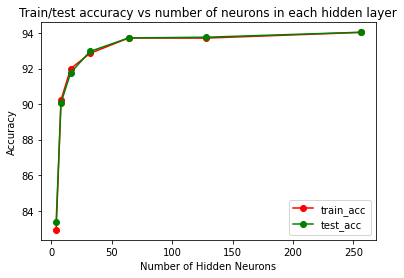

In [ ]:
plt.plot(hidden_neurons_values, mlp_train_accs, 'o-g', color='red')
plt.plot(hidden_neurons_values, mlp_test_accs, 'o-g', color='green')
plt.ylabel('Accuracy')
plt.xlabel('Number of Hidden Neurons')
plt.title('Train/test accuracy vs number of neurons in each hidden layer')
plt.legend(["train_acc", "test_acc"], loc="lower right")
plt.show()

## 3. LeNet-5

In [4]:
# LeNet-5 implementation
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pub.towardsai.net/the-architecture-implementation-of-lenet-5-eef03a68d1f7
        # in: B*1*28*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=0, stride=1)
        # out(C1): B*6*24*24
        # out(S2): B*6*12*12
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), padding=(1,1), stride=1) 
        # out(C3): B*16*10*10
        # out(S4): B*16*5*5
        self.fc1 = nn.Linear(16*5*5, 120)
        # out(C5): B*120
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x)) # layer C1
        x = F.avg_pool2d(x, kernel_size=(2, 2), stride=2) # layer S2
        x = torch.tanh(self.conv2(x)) # layer C3
        x = F.avg_pool2d(x, kernel_size=(2, 2), stride=2) # layer S4
        x = x.view(-1, 400) # flatten to convert B*16*5*5 into B*400
        x = torch.tanh(self.fc1(x)) # layer C5
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x) # no needs softmax since torch.nn.CrossEntropyLoss comes with it already
        return x

net_model = LeNet()
net_optimizer = torch.optim.SGD(net_model.parameters(), lr=0.005)

# train the model
train(net_model, dataloaders, net_optimizer, reshape_inputs=False)

net_train_acc = compute_acc(net_model, 'train', reshape_inputs=False)
net_test_acc = compute_acc(net_model, 'test', reshape_inputs=False)

print("Training accuracy: {}" .format(net_train_acc))
print("Testing accuracy: {}" .format(net_test_acc))

[Epoch 1] test acc: 49.47%, loss: 0.03223429646492004


[Epoch 2] test acc: 78.42%, loss: 0.013896052604913712


[Epoch 3] test acc: 86.74%, loss: 0.00829595719575882


[Epoch 4] test acc: 89.12%, loss: 0.00649757162630558


[Epoch 5] test acc: 90.31%, loss: 0.005556900680065155


[Epoch 6] test acc: 90.93%, loss: 0.004999799959361553


[Epoch 7] test acc: 91.60000000000001%, loss: 0.004603615926206112


[Epoch 8] test acc: 92.17%, loss: 0.004267925548553467


[Epoch 9] test acc: 92.64%, loss: 0.0040052958957850935


[Epoch 10] test acc: 93.05%, loss: 0.0037420074000954627


[Epoch 11] test acc: 93.5%, loss: 0.0035176699340343474


[Epoch 12] test acc: 93.81%, loss: 0.0032972461357712746


[Epoch 13] test acc: 94.17999999999999%, loss: 0.003104395408555865


[Epoch 14] test acc: 94.44%, loss: 0.0029214073654264213


[Epoch 15] test acc: 94.74000000000001%, loss: 0.002763741548359394


[Epoch 16] test acc: 94.92%, loss: 0.0026180857740342616


[Epoch 17] test acc: 95.32000000000001%, loss: 0.002479878208786249


[Epoch 18] test acc: 95.62%, loss: 0.0023829514596611263


[Epoch 19] test acc: 95.75%, loss: 0.002229155522212386


[Epoch 20] test acc: 95.98%, loss: 0.0021232037257403135
Training accuracy: 95.87
Testing accuracy: 95.98


The test accuracy of the LeNet-5 model is the value of net_test_acc i.e. 95.98%.

## 4. Context Aggregation Network

In [ ]:
# CAN implementation
class CAN(nn.Module):
    def __init__(self, num_feature_channels=32):
        super().__init__()
        # 3*3 then 5*5 then 9*9 then 17*17 then 3*3 kernel
        # assuming stride (1,1) padding (p,p) with kernel size (k,k) and input (B,F,m,m) (F = number of feature channels)
        # dilated kernel will have 'size' (1+(k-1)*d, 1+(k-1)*d)
        # there will be m-(1+(k-1)*d)+1+2p of these applied to each (m,m)-sized channel so total m-d(k-1)+2p results
        # input: B*1*28*28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_feature_channels, kernel_size=(3,3), padding=(1,1), stride=1, dilation=1) 
        # out: B*F*28*28
        self.conv2 = nn.Conv2d(in_channels=num_feature_channels, out_channels=num_feature_channels, kernel_size=(3,3), padding=(1,1), stride=1, dilation=2) 
        # out: B*F*26*26
        self.conv3 = nn.Conv2d(in_channels=num_feature_channels, out_channels=num_feature_channels, kernel_size=(3,3), padding=(1,1), stride=1, dilation=4)
        # out: B*F*20*20
        self.conv4 = nn.Conv2d(in_channels=num_feature_channels, out_channels=num_feature_channels, kernel_size=(3,3), padding=(1,1), stride=1, dilation=8)
        # out: B*F*6*6
        self.conv5 = nn.Conv2d(in_channels=num_feature_channels, out_channels=10, kernel_size=(3,3), padding=0, stride=1, dilation=1)
        # out: B*10*4*4

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        # global average pooling implementation: https://discuss.pytorch.org/t/global-average-pooling-in-pytorch/6721/3
        # this means that after conv5 layer, the output is B*10*4*4, with each of the 10 feature maps having size 4*4.
        # global average pooling means we average each of the values in each feature map to make up a 10-dimensional vector
        x = F.avg_pool2d(x, kernel_size=(4,4))
        x = x.view(-1, 10) # flatten to convert into B*10
        return x

feature_channels_list = [32, 8, 64]

for i in range(len(feature_channels_list)):
    can_model = CAN(num_feature_channels=feature_channels_list[i])
    can_optimizer = torch.optim.SGD(can_model.parameters(), lr=0.005)
    print("============== [{} feature channels in CAN] ==============" .format(feature_channels_list[i]))

    # train the model
    train(can_model, dataloaders, can_optimizer, reshape_inputs=False)

    can_train_acc = compute_acc(can_model, 'train', reshape_inputs=False)
    can_test_acc = compute_acc(can_model, 'test', reshape_inputs=False)

    print("Training accuracy: {}" .format(can_train_acc))
    print("Testing accuracy: {}" .format(can_test_acc))

============== [32 feature channels in CAN] ==============


[Epoch 1] test acc: 10.280000000000001%, loss: 0.03612471148967743


[Epoch 2] test acc: 10.290000000000001%, loss: 0.03607550961971283


[Epoch 3] test acc: 28.549999999999997%, loss: 0.035874327397346494


[Epoch 4] test acc: 48.010000000000005%, loss: 0.02764397532939911


[Epoch 5] test acc: 86.53999999999999%, loss: 0.0072565409198403355


[Epoch 6] test acc: 89.7%, loss: 0.00548106966689229


[Epoch 7] test acc: 91.25%, loss: 0.004623120883852244


[Epoch 8] test acc: 92.58999999999999%, loss: 0.0038237975403666497


[Epoch 9] test acc: 92.85%, loss: 0.00379744985550642


[Epoch 10] test acc: 94.15%, loss: 0.0030245965119451283


[Epoch 11] test acc: 94.49%, loss: 0.002743952402472496


[Epoch 12] test acc: 95.45%, loss: 0.0023784934197552503


[Epoch 13] test acc: 95.7%, loss: 0.0021181523092091083


[Epoch 14] test acc: 96.31%, loss: 0.0019121364686638116


[Epoch 15] test acc: 96.04%, loss: 0.0019828131061047317


[Epoch 16] test acc: 96.84%, loss: 0.0015688254373148083


[Epoch 17] test acc: 95.33%, loss: 0.0022074359515681864


[Epoch 18] test acc: 96.17999999999999%, loss: 0.0018634039223194123


[Epoch 19] test acc: 96.99%, loss: 0.0014979052504291758


[Epoch 20] test acc: 97.25%, loss: 0.0014016829348169268
Training accuracy: 97.135
Testing accuracy: 97.25
============== [8 feature channels in CAN] ==============


[Epoch 1] test acc: 11.35%, loss: 0.03614779331684113


[Epoch 2] test acc: 11.35%, loss: 0.036138818526268005


[Epoch 3] test acc: 11.35%, loss: 0.03613559103012085


[Epoch 4] test acc: 11.35%, loss: 0.03613332235813141


[Epoch 5] test acc: 11.35%, loss: 0.036131880402565


[Epoch 6] test acc: 11.35%, loss: 0.03613016314506531


[Epoch 7] test acc: 11.35%, loss: 0.036127577662467956


[Epoch 8] test acc: 11.35%, loss: 0.03612411806583404


[Epoch 9] test acc: 11.35%, loss: 0.03612096190452576


[Epoch 10] test acc: 11.35%, loss: 0.036111190390586856


[Epoch 11] test acc: 11.35%, loss: 0.036092964220047


[Epoch 12] test acc: 11.35%, loss: 0.036050390219688415


[Epoch 13] test acc: 20.1%, loss: 0.035818769264221194


[Epoch 14] test acc: 23.59%, loss: 0.03302386591434479


[Epoch 15] test acc: 73.28%, loss: 0.013649256992340087


[Epoch 16] test acc: 82.55%, loss: 0.00895220417380333


[Epoch 17] test acc: 85.35000000000001%, loss: 0.007616376610100269


[Epoch 18] test acc: 88.22%, loss: 0.006067244859039783


[Epoch 19] test acc: 89.89%, loss: 0.005380340752005577


[Epoch 20] test acc: 90.19%, loss: 0.005053524489700794
Training accuracy: 89.46333333333332
Testing accuracy: 90.19
============== [64 feature channels in CAN] ==============


[Epoch 1] test acc: 21.4%, loss: 0.0360085098028183


[Epoch 2] test acc: 39.08%, loss: 0.03044387764930725


[Epoch 3] test acc: 84.52%, loss: 0.008208857926726341


[Epoch 4] test acc: 90.25%, loss: 0.005199513436853886


[Epoch 5] test acc: 91.13%, loss: 0.004696228730678559


[Epoch 6] test acc: 93.52000000000001%, loss: 0.0033044709891080857


[Epoch 7] test acc: 94.08999999999999%, loss: 0.0031621937181800603


[Epoch 8] test acc: 95.35%, loss: 0.0024412262324243783


[Epoch 9] test acc: 95.78%, loss: 0.00225160318762064


[Epoch 10] test acc: 96.39%, loss: 0.0018784346057102083


[Epoch 11] test acc: 96.03%, loss: 0.00197823449652642


[Epoch 12] test acc: 96.78%, loss: 0.0016104907030239702


[Epoch 13] test acc: 97.11%, loss: 0.001572402194980532


[Epoch 14] test acc: 97.34%, loss: 0.0013837533060926943


[Epoch 15] test acc: 97.15%, loss: 0.0014677796319127084


[Epoch 16] test acc: 97.37%, loss: 0.0013382542933337391


[Epoch 17] test acc: 97.46000000000001%, loss: 0.0012405178291723133


[Epoch 18] test acc: 97.45%, loss: 0.001321889850217849


[Epoch 19] test acc: 97.50999999999999%, loss: 0.0012738945061340928


[Epoch 20] test acc: 97.43%, loss: 0.001192637199163437
Training accuracy: 97.49666666666667
Testing accuracy: 97.43


The test accuracy of the CAN model is given by can_test_acc i.e. 97.25%. As seen from the test accuracies of the CAN model for different number of feature channels, the test accuracy decreases as the number of feature channels decrease. This makes sense since the output of each convolution is a feature map, and with fewer output feature channels, the network has less features to work with to infer which class the image actually belongs to. As the number of feature channels increases, the test accuracy increases slightly, however this change is probably negligible since at a certain point, more feature maps offer no additional useful information for classification (i.e. 32 feature maps may already be 'enough' info.)